# Solution

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch

In [18]:
from ddpg_agent import DDPGAgent

# Load Reacher environment

In [4]:
env = UnityEnvironment(file_name='Reacher_Linux1/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Explore environment states and actions

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


# Architecture details

In [9]:
in_actor = state_size
in_critic = state_size + action_size

hidden_in_actor = 256
hidden_out_actor = 128
hidden_in_critic = 256
hidden_out_critic = 128

out_actor = action_size

## Load agent

In [10]:
agent = DDPGAgent(in_actor, hidden_in_actor, hidden_out_actor, out_actor, in_critic, hidden_in_critic, hidden_out_critic)
num_agents = len(env_info.agents)

## Traininig the ddpg agent to solve Reacher 1

In [11]:
def ddpg_train(n_episodes=600, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_windows = []
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    for i_episode in range(1, n_episodes+1):
        #print(i_episode)
        #import pdb;pdb.set_trace()
        env_info = env.reset(train_mode = True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0   
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            #print(done)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        scores_windows.append(np.mean(scores_window))
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        #print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if i_episode % 100 == 0:
            torch.save(agent.target_actor.state_dict(), f'checkpoint{i_episode}.pth')
        if np.mean(scores_window)>=30:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.target_actor.state_dict(), f'best_checkpoint{i_episode}.pth')
    return scores, scores_windows

In [12]:
scores, scores_windows = ddpg_train()

Episode 10	Average Score: 0.15
Episode 20	Average Score: 0.17
Episode 30	Average Score: 0.17
Episode 40	Average Score: 0.25
Episode 50	Average Score: 0.28
Episode 60	Average Score: 0.34
Episode 70	Average Score: 0.37
Episode 80	Average Score: 0.40
Episode 90	Average Score: 0.39
Episode 100	Average Score: 0.42
Episode 110	Average Score: 0.49
Episode 120	Average Score: 0.54
Episode 130	Average Score: 0.61
Episode 140	Average Score: 0.67
Episode 150	Average Score: 0.78
Episode 160	Average Score: 0.96
Episode 170	Average Score: 1.17
Episode 180	Average Score: 1.43
Episode 190	Average Score: 1.80
Episode 200	Average Score: 2.13
Episode 210	Average Score: 2.44
Episode 220	Average Score: 2.74
Episode 230	Average Score: 3.21
Episode 240	Average Score: 3.55
Episode 250	Average Score: 3.93
Episode 260	Average Score: 4.19
Episode 270	Average Score: 4.45
Episode 280	Average Score: 4.90
Episode 290	Average Score: 5.31
Episode 300	Average Score: 5.79
Episode 310	Average Score: 6.16
Episode 320	Avera

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

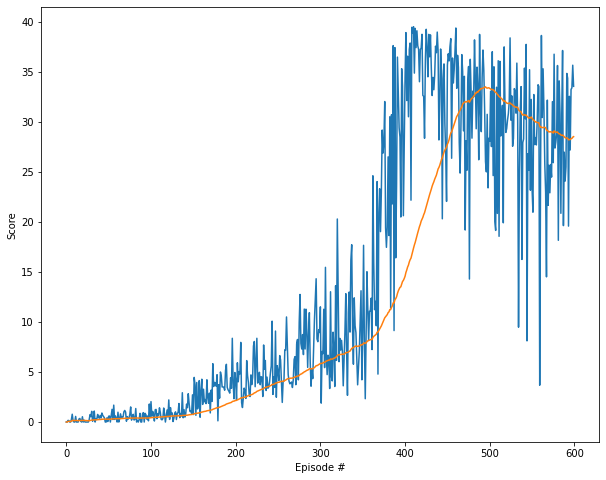

In [20]:
# plot the scores
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(scores_windows)), scores_windows)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()